# Lectura de los datos
Simplemente realizamos la lectura de los datos de la base de datos MongoDB con las credenciales utilizadas en el script `db_insert.py`

In [1]:
import pandas as pd
from pymongo import MongoClient

# Read all the data and store it into a dataframe
myclient = MongoClient("mongodb://localhost:27017")
db = myclient["robin"]
collection = db["testPythonDB"]
df_products = pd.DataFrame(list(collection.find({})))


# Preparacion de los datos
Nos quedamos con los datos que necesitamos y que vamos a utilizar para en el siguiente paso entrenar nuestros modelos.
Este es el paso mas largo y uno de los mas importantes. Recordar siempre la regla GIGO (Garbage In - Garbage Out), es decir, por muy bueno que sea nuestro modelo, si lo entrenamos con basura, sus predicciones seran una basura.

In [2]:
import matplotlib.pyplot as plt

# Solo necesitamos dos columnas: name = descripcion y brandName = etiqueta
keep_columns = ["name", "brandName"]
df_products = df_products[keep_columns]

# Eliminamos las filas de las que no sabemos la marca
df_products = df_products[df_products.brandName != "NO IDENTIFICADA"]
df_products.dropna(inplace=True)


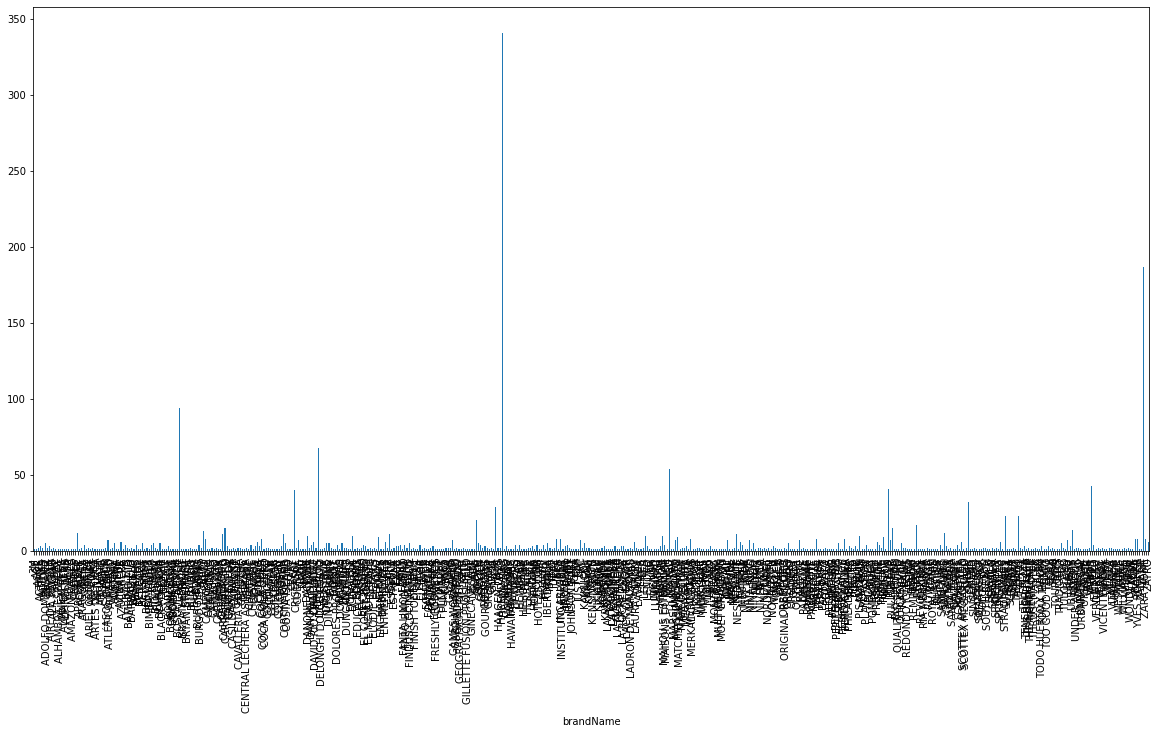

In [3]:
# Vemos cuantos productos hay por marca, al haber muchas marcas no se vera muy bien
fig = plt.figure(figsize=(20,10))
df_products.groupby('brandName').name.count().plot.bar(ylim=0)
plt.show()

Como habiamos comentado, la visualizacion no es la mejor, pero nos da una idea de lo poco balanceadas que estan las clases. Es decir, hay muchisimos items de unas pocas marcas mientras que de otras hay muy pocos o incluso solo una. Con estos problemas, suele costar utilizar algoritmos mas estandar dado que no lo tienen en cuenta y acaban teniendo un sesgo demasiado grande hacia las clases mayoritarias. Sin embargo, en nuestro caso igual no es tan problematico acabar prediciendo mas veces hacia las marcas mas representadas en el dataset dado que puede ser una buena representacion de la realidad. Es decir, marcas como ZARA son mas vendidas que, por ejemplo, SPONTEX o ACE (por decir dos).

A continuacion utilizaremos TF-IDF para crear un vector para cada descripcion de item. Esta tecnica es muy utilizada dado que depende de dos metricas: el número de veces que una palabra aparece en un dato y la frecuencia inversa de la palabra en un conjunto de datos, dado asi una metrica relativa al dataset que estamos utilizando.

In [4]:
from io import StringIO
df_products = df_products[pd.notnull(df_products['name'])]
df_products['brandId'] = df_products['brandName'].factorize()[0]
brand_id_df = df_products[['brandName', 'brandId']].drop_duplicates().sort_values('brandId')
brand_to_id = dict(brand_id_df.values)
id_to_brand = dict(brand_id_df[['brandId', 'brandName']].values)

from sklearn.feature_extraction.text import TfidfVectorizer
# Leemos las stopwords en español dado que no estan definidas por sklearn
import unidecode
with open("stop-words-spanish.txt") as f:
    stopwords = f.readlines()
stopwords = [unidecode.unidecode(x.strip()) for x in stopwords] 

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords)
features = tfidf.fit_transform(df_products.name).toarray()
labels = df_products['brandId']

In [5]:
df_products.reset_index()

,index,name,brandName,brandId
0,0,menu familiar,BURGER KING,0
1,1,Televisor Samsung 65'',SAMSUNG,1
2,4,menu familiar,BURGER KING,0
3,5,Licencia windows 10 PRO,MICROSOFT,2
4,6,webcam playstation 4,PLAYSTATION,3
...,...,...,...,...
2183,2691,"2 x Nivea - Hidratante, pack de 4(4 x 50 ml)",NIVEA,459
2184,2693,COCA COLA clásica pack 2 botellas 2 lt,COCA COLA,92
2185,2696,COCA COLA light sin cafeína lata 33 cl,COCA COLA LIGHT,513
2186,2697,EL CASERIO queso fundido burger con cheddar en...,EL CASERIO,358


In [6]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for brand, brandId in sorted(brand_to_id.items()):
  features_chi2 = chi2(features, labels == brandId)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print(f"# '{brand}':")
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


# '3M':
  . Most correlated unigrams:
. protector
. honda
  . Most correlated bigrams:
. bosque verde
. hacendado paquete
# 'ACE':
  . Most correlated unigrams:
. gel
. 700
  . Most correlated bigrams:
. bosque verde
. hacendado paquete
# 'ACOR':
  . Most correlated unigrams:
. kg
. azucar
  . Most correlated bigrams:
. hacendado paquete
. paquete kg
# 'ACTIMEL':
  . Most correlated unigrams:
. total
. 14
  . Most correlated bigrams:
. ml total
. 100 ml
# 'ACTIVIA':
  . Most correlated unigrams:
. semillas
. 480
  . Most correlated bigrams:
. paquete de
. gr total
# 'ADIDAS':
  . Most correlated unigrams:
. zapatillas
. hombre
  . Most correlated bigrams:
. de running
. zapatillas de
# 'ADOLFO DOMINGUEZ':
  . Most correlated unigrams:
. punto
. lino
  . Most correlated bigrams:
. hacendado paquete
. vestido de
# 'AIRBNB':
  . Most correlated unigrams:
. de
. servicio
  . Most correlated bigrams:
. hacendado paquete
. servicio de
# 'AIRE DE SEVILLA':
  . Most correlated unigrams:
. hidr

Podemos ver que algunos valores tienen mucho sentido mientras que otros solamente aparecen dado el desbalance de los datos. Procedere con los modelos dado que esto implicaria un estudio mucho mas detallado y exhaustivo de los datos y no tengo tiempo para ello.

# Modelos predictivos

Una vez ya tenemos los datos, el siguiente paso es entrenar un modelo con ellos. En este caso, realizaremos el entrenamiento de 4 modelos de clasificacion distintos: RandomForest, MultinomialNB (Naive Bayes), LinearSVC y LogisticRegression.

Utilizaremos la tecnica de validacion cruzada con todos ellos para ver cual de los cuatro nos da mejores resultados

/home/vscode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/vscode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/vscode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/vscode/.local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


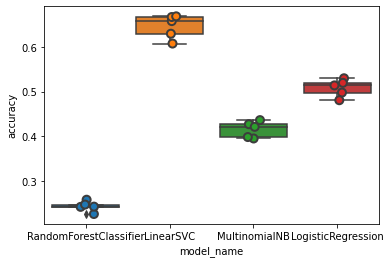

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [8]:
# Por ultimo comparamos la precision media de estos modelos
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.645798
LogisticRegression        0.508219
MultinomialNB             0.415443
RandomForestClassifier    0.243146
Name: accuracy, dtype: float64

Podemos ver que aunque todos los resultados son algo decepcionantes, el que mejor se comporta es la maquina de soporte LinearSVC.
Ahora realizaremos una evaluacion de este modelo.

In [10]:
from sklearn.model_selection import train_test_split

model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_products.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

from sklearn import metrics
# Como tenemos un problema con el balance, no tenemos el mismo numero de clases
# en el dataset que en la prediccion + test
brandIds = np.unique(np.append(y_pred, y_test.values))
brands = df_products[np.isin(df_products['brandId'].values, brandIds)].brandName.unique()

print(metrics.classification_report(y_test, y_pred, target_names=brands))

                      precision    recall  f1-score   support

         BURGER KING       0.00      0.00      0.00         1
             SAMSUNG       1.00      1.00      1.00         5
           MICROSOFT       0.00      0.00      0.00         0
         PLAYSTATION       0.00      0.00      0.00         3
             HAWKERS       0.50      0.33      0.40         3
              LENOVO       0.00      0.00      0.00         1
          LA FALLERA       0.00      0.00      0.00         0
           CARREFOUR       0.50      0.33      0.40         3
            KOIPESOL       1.00      1.00      1.00         2
              CINESA       0.75      1.00      0.86         3
   MATCHSTICK MONKEY       0.00      0.00      0.00         1
             BROTHER       0.00      0.00      0.00         1
DAVID RIO CHAI LATTE       1.00      1.00      1.00         1
              MISAKO       0.00      0.00      0.00         2
            JUST EAT       1.00      0.50      0.67         2
       

Como podemos ver, en las marcas en las que tenemos un soporte mayor, es en las que mas acertamos.